In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import interactive
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from mlxtend.plotting import plot_decision_regions
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score  
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from random import randint

In [2]:
data = pd.read_csv('C:/Users/prof-/OneDrive/Рабочий стол/ПНИПУ/FinanceMath/tickers/All_specs1.csv')
data.head(1)

,Trend,STD_Trend,Vol,LN_Vol,STD_Vol,Hurst,STD_Hurst,Option,Res,CallOnly,PutOnly,TrueRes
0,-0.547334,-1.017391,0.393758,-0.932019,0.54827,0.640542,1.111607,Put,-1.0,1.008462,-1.0,-1.0


In [3]:
data[['Trend', 'Vol', 'Hurst', 'TrueRes']].describe()
#data['TrueRes'].describe()

,Trend,Vol,Hurst,TrueRes
count,24186.000000,24186.000000,24186.000000,24186.000000
mean,0.070078,0.335072,0.577282,0.324151
std,0.606870,0.205936,0.056909,2.681330
min,-4.276630,0.017708,0.273775,-1.000000
25%,-0.137588,0.175510,0.540265,-1.000000
50%,0.101228,0.285518,0.577346,-0.970215
75%,0.355050,0.453023,0.614607,0.691841
max,4.657632,0.999369,0.827781,56.049352


In [4]:
code = {"Option": {"Call": 1, "Put": -1}}
data = data.replace(code)
data['Option'] = np.where((data.CallOnly == -1), -1, data.Option)
data['Option'] = np.where((data.CallOnly != -1), 1, data.Option)
data.head(1)

,Trend,STD_Trend,Vol,LN_Vol,STD_Vol,Hurst,STD_Hurst,Option,Res,CallOnly,PutOnly,TrueRes
0,-0.547334,-1.017391,0.393758,-0.932019,0.54827,0.640542,1.111607,1,-1.0,1.008462,-1.0,-1.0


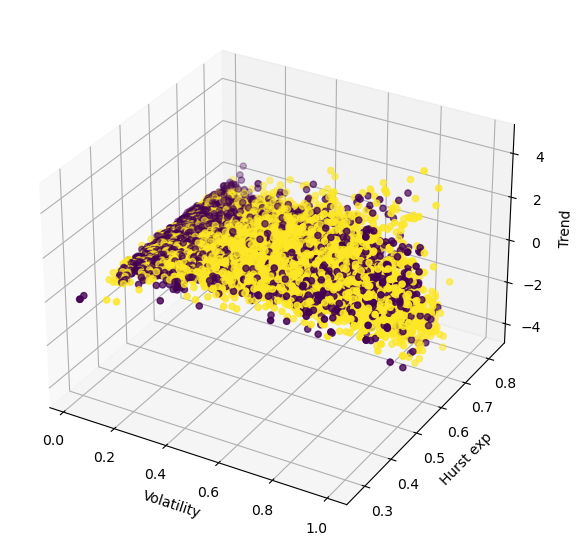

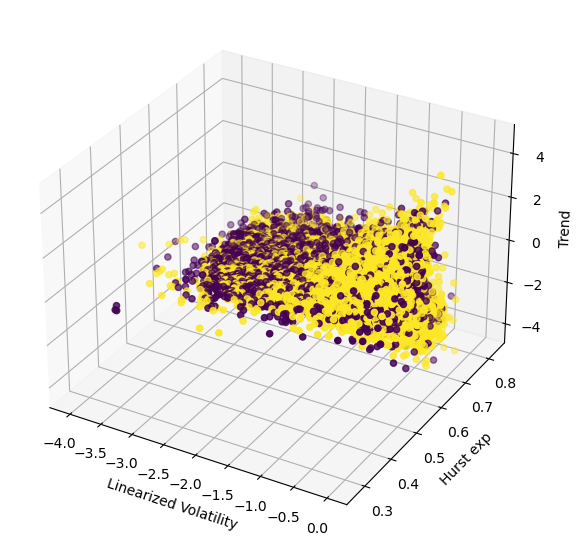

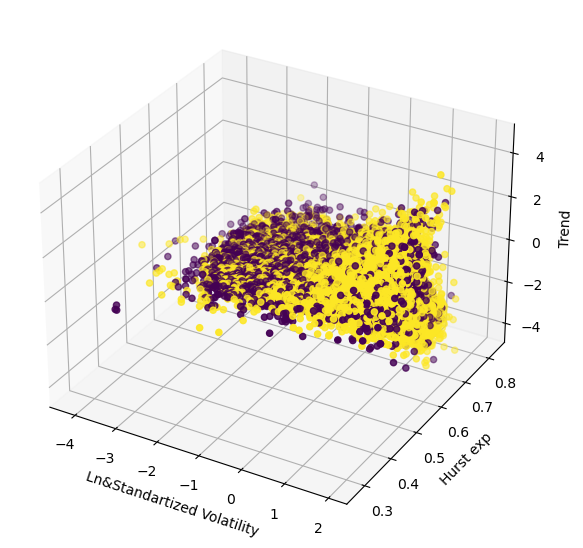

In [36]:
fig = plt.figure(figsize=(7,7), dpi = 100)
ax = fig.add_subplot(111, projection='3d')

x = data['Vol']
y =data['Hurst']
z =data['Trend']

ax.scatter3D(x, y, z, c=data['Option'])
interactive(True)

ax.set_xlabel('Volatility')
ax.set_ylabel('Hurst exp')
ax.set_zlabel('Trend')

fig1 = plt.figure(figsize=(7,7), dpi = 100)
ax1 = fig1.add_subplot(111, projection='3d')
interactive(True)

x1 = data['LN_Vol']
y1 =data['Hurst']
z1 =data['Trend']

ax1.scatter3D(x1, y1, z1, c=data['Option'])

ax1.set_xlabel('Linearized Volatility')
ax1.set_ylabel('Hurst exp')
ax1.set_zlabel('Trend')

fig2 = plt.figure(figsize=(7,7), dpi = 100)
ax2 = fig2.add_subplot(111, projection='3d')
interactive(True)

x2 = data['STD_Vol']
y2 =data['Hurst']
z2 =data['Trend']

ax2.scatter3D(x2, y2, z2, c=data['Option'])

ax2.set_xlabel('Ln&Standardized Volatility')
ax2.set_ylabel('Hurst exp')
ax2.set_zlabel('Trend')

plt.show()
#raw.input()

In [59]:
#Create different datasets for ML methods || Lets try only stochastic
#Basic dataset
base_data = data.copy()
#base_data = base_data.drop(['STD_Trend', 'STD_Vol', 'LN_Vol', 'Res', 'CallOnly', 'PutOnly', 'STD_Hurst'], axis = 1)
#base_data = base_data.drop(['STD_Trend', 'STD_Vol', 'LN_Vol', 'Res', 'CallOnly', 'PutOnly', 'STD_Hurst', 'Hurst'], axis = 1)
base_data = base_data.drop(['STD_Trend', 'STD_Vol', 'LN_Vol', 'Res', 'CallOnly', 'PutOnly', 'STD_Hurst', 'Vol','Trend'], axis = 1)
base_data.head(1)

,Hurst,Option,TrueRes
0,0.640542,1,-1.0


In [85]:
#Standardized dataset
std_data = data.copy()
std_data = std_data.drop(['Trend', 'Vol', 'LN_Vol', 'Res', 'CallOnly', 'PutOnly', 'STD_Trend','STD_Vol','Hurst'], axis = 1)
std_data.head(1)

,STD_Hurst,Option,TrueRes
0,1.111607,1,-1.0


In [128]:
#Linearized volatility dataset
ln_data = data.copy()
#ln_data = ln_data.drop(['Trend', 'STD_Vol', 'Vol', 'Res', 'CallOnly', 'PutOnly', 'Hurst'], axis = 1)
ln_data = ln_data.drop(['STD_Trend', 'STD_Vol', 'Vol', 'Res', 'CallOnly', 'PutOnly', 'STD_Hurst','Hurst'], axis = 1)
ln_data.head(1)

,Trend,LN_Vol,Option,TrueRes
0,-0.547334,-0.932019,1,-1.0


In [7]:
#Cleaned by abnormalities base dataset
cl_data = data.copy()
cl_bdata = data.copy()
cl_data = cl_data.drop(['STD_Trend', 'STD_Vol', 'LN_Vol', 'Res', 'CallOnly', 'PutOnly', 'STD_Hurst'], axis = 1)

Q1 =  cl_data['Trend'].quantile(0.25)
Q3 = cl_data['Trend'].quantile(0.75)
IQR = Q3 - Q1
cl_data = cl_data[(cl_data['Trend'] > (Q1-1.5*IQR)) & (cl_data['Trend'] < (Q3+1.5*IQR))]
cl_bdata = cl_bdata[(cl_bdata['Trend'] > (Q1-1.5*IQR)) & (cl_bdata['Trend'] < (Q3+1.5*IQR))]

Q1 =  cl_data['Vol'].quantile(0.25)
Q3 = cl_data['Vol'].quantile(0.75)
IQR = Q3 - Q1
cl_data = cl_data[(cl_data['Vol'] > (Q1-1.5*IQR)) & (cl_data['Vol'] < (Q3+1.5*IQR))]
cl_bdata = cl_bdata[(cl_bdata['Vol'] > (Q1-1.5*IQR)) & (cl_bdata['Vol'] < (Q3+1.5*IQR))]

Q1 =  cl_data['Hurst'].quantile(0.25)
Q3 = cl_data['Hurst'].quantile(0.75)
IQR = Q3 - Q1
cl_data = cl_data[(cl_data['Hurst'] > (Q1-1.5*IQR)) & (cl_data['Hurst'] < (Q3+1.5*IQR))]
cl_bdata = cl_bdata[(cl_bdata['Hurst'] > (Q1-1.5*IQR)) & (cl_bdata['Hurst'] < (Q3+1.5*IQR))]

#cl_data.boxplot(column="Trend")
cl_data.head(1)

,Trend,Vol,Hurst,Option
0,-0.547334,0.393758,0.640542,1


In [8]:
#Cleaned by abnormalities standardized dataset
std_cl_data = data.copy()
std_cl_bdata = data.copy()
std_cl_data = std_cl_data.drop(['Trend', 'Vol', 'LN_Vol', 'Res', 'CallOnly', 'PutOnly', 'Hurst'], axis = 1)
std_cl_data.head(1)

Q1 =  std_cl_data['STD_Trend'].quantile(0.25)
Q3 = std_cl_data['STD_Trend'].quantile(0.75)
IQR = Q3 - Q1
std_cl_data = std_cl_data[(std_cl_data['STD_Trend'] > (Q1-1.5*IQR)) & (std_cl_data['STD_Trend'] < (Q3+1.5*IQR))]
std_cl_bdata = std_cl_bdata[(std_cl_bdata['STD_Trend'] > (Q1-1.5*IQR)) & (std_cl_bdata['STD_Trend'] < (Q3+1.5*IQR))]

Q1 =  std_cl_data['STD_Vol'].quantile(0.25)
Q3 = std_cl_data['STD_Vol'].quantile(0.75)
IQR = Q3 - Q1
std_cl_data = std_cl_data[(std_cl_data['STD_Vol'] > (Q1-1.5*IQR)) & (std_cl_data['STD_Vol'] < (Q3+1.5*IQR))]
std_cl_bdata = std_cl_bdata[(std_cl_bdata['STD_Vol'] > (Q1-1.5*IQR)) & (std_cl_bdata['STD_Vol'] < (Q3+1.5*IQR))]

Q1 =  std_cl_data['STD_Hurst'].quantile(0.25)
Q3 = std_cl_data['STD_Hurst'].quantile(0.75)
IQR = Q3 - Q1
std_cl_data = std_cl_data[(std_cl_data['STD_Hurst'] > (Q1-1.5*IQR)) & (std_cl_data['STD_Hurst'] < (Q3+1.5*IQR))]
std_cl_bdata = std_cl_bdata[(std_cl_bdata['STD_Hurst'] > (Q1-1.5*IQR)) & (std_cl_bdata['STD_Hurst'] < (Q3+1.5*IQR))]

#cl_data.boxplot(column="Trend")
std_cl_data.head(1)

,STD_Trend,STD_Vol,STD_Hurst,Option
0,-1.017391,0.54827,1.111607,1


In [9]:
#Cleaned by abnormalities linearized dataset
ln_cl_data = data.copy()
ln_cl_bdata = data.copy()
ln_cl_data = ln_cl_data.drop(['STD_Trend', 'Vol', 'STD_Vol', 'Res', 'CallOnly', 'PutOnly', 'STD_Hurst'], axis = 1)
ln_cl_data.head(1)

Q1 =  ln_cl_data['Trend'].quantile(0.25)
Q3 = ln_cl_data['Trend'].quantile(0.75)
IQR = Q3 - Q1
ln_cl_data = ln_cl_data[(ln_cl_data['Trend'] > (Q1-1.5*IQR)) & (ln_cl_data['Trend'] < (Q3+1.5*IQR))]
ln_cl_bdata = ln_cl_bdata[(ln_cl_bdata['Trend'] > (Q1-1.5*IQR)) & (ln_cl_bdata['Trend'] < (Q3+1.5*IQR))]

Q1 =  ln_cl_data['LN_Vol'].quantile(0.25)
Q3 = ln_cl_data['LN_Vol'].quantile(0.75)
IQR = Q3 - Q1
ln_cl_data = ln_cl_data[(ln_cl_data['LN_Vol'] > (Q1-1.5*IQR)) & (ln_cl_data['LN_Vol'] < (Q3+1.5*IQR))]
ln_cl_bdata = ln_cl_bdata[(ln_cl_bdata['LN_Vol'] > (Q1-1.5*IQR)) & (ln_cl_bdata['LN_Vol'] < (Q3+1.5*IQR))]

Q1 =  ln_cl_data['Hurst'].quantile(0.25)
Q3 = ln_cl_data['Hurst'].quantile(0.75)
IQR = Q3 - Q1
ln_cl_data = ln_cl_data[(ln_cl_data['Hurst'] > (Q1-1.5*IQR)) & (ln_cl_data['Hurst'] < (Q3+1.5*IQR))]
ln_cl_bdata = ln_cl_bdata[(ln_cl_bdata['Hurst'] > (Q1-1.5*IQR)) & (ln_cl_bdata['Hurst'] < (Q3+1.5*IQR))]

#cl_data.boxplot(column="Trend")
ln_cl_data.head(1)

,Trend,LN_Vol,Hurst,Option
0,-0.547334,-0.932019,0.640542,1


In [10]:
# Create datasets for ML || Need to rearrange for each data: base, ln, std, cleaned...
# Base as a baseline
X = base_data.iloc[:,:-2]
Y = base_data['Option'] 
X.head(1)

,Trend,Vol
0,-0.547334,0.393758


In [11]:
# Create datasets for train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3) 

In [12]:
# Now train ML methods
# Here we train SVM
SVC_model = svm.SVC(kernel='linear')
SVC_model.fit(X_train, y_train)
ans = SVC_model.predict(X_test)
print(accuracy_score(ans, y_test))

0.6471682513435304


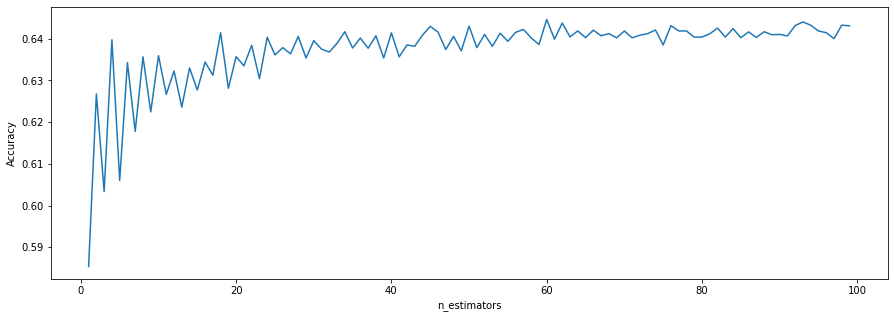

In [104]:
# Random forest regressor. We can change continious data as binary with conditions < or > 0
Q = []
max_score = 0
for n_est in range(1, 100):
    RF_model = RandomForestRegressor(n_estimators=n_est,
                              max_features=0.2)
    RF_model.fit(X_train, y_train)
    A = RF_model.predict(X_test)
    A = np.where((A < 0), -1, A)
    A = np.where((A >= 0), 1, A)
    Q.append(accuracy_score(y_test, A))

fig = plt.figure(figsize=(15,5))
plt.plot(range(1, 100), Q)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
#plt.ylim(0.6, 0.7)
plt.show()
#max acc with max n_est in average, though 46 for the example below

Maxscore =  0.6591566763125258 Max depth =  19 Min leafs =  32


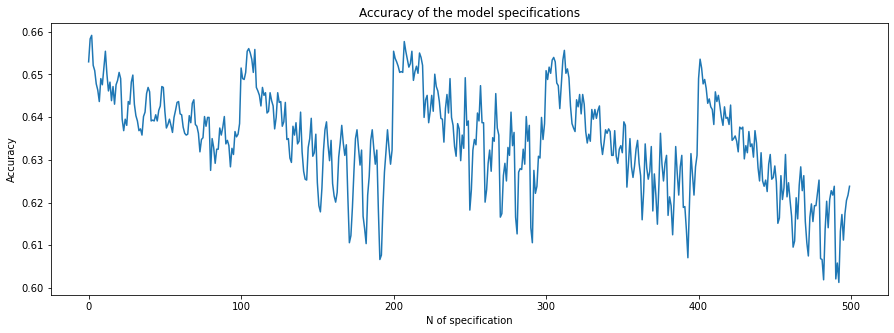

In [12]:
#Simple decision tree
history = []
max_score = 0
md = 0
ms = 0

for r in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20+r) 
    
    for max_depth in range(10, 20):
        for min_samples_leaf in range(5, 35, 3):
            DT_model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=r)
            DT_model.fit(X_train, y_train)
            score = accuracy_score(DT_model.predict(X_test), y_test)
            history.append(accuracy_score(DT_model.predict(X_test), y_test))
            if score > max_score:
                max_score = score
                md = max_depth
                ms = min_samples_leaf
            #print("max_depth = ", max_depth, "min_samples = ", min_samples_leaf, "r = ", r, history[len(history)-1])
    
print("Maxscore = ", max_score, "Max depth = ", max_depth, "Min leafs = ", min_samples_leaf)
plt.figure(figsize=(15, 5))
#plt.ylim((0.6, 0.7))
plt.plot(history)
plt.title('Accuracy of the model specifications')
plt.xlabel('N of specification')
plt.ylabel('Accuracy')
plt.show() 
# Max score with depth 19 and leafs 32

In [13]:
his = pd.DataFrame(history)
writer = pd.ExcelWriter('C:/Users/prof-/OneDrive/Рабочий стол/ПНИПУ/FinanceMath/datas/dthist.xlsx', engine= 'xlsxwriter')
his.to_excel(writer, 'Sheet1')
writer.save()

In [ ]:
# Logistic regression training
median = -1
mean = -1
m_index = 0
s_index = 0

for i in range (111):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.95, random_state=i) 
    clf = LogisticRegression(random_state=220-i).fit(X_train, y_train)
    answ = clf.predict(X)
        
    data1 = data.copy()
    data1['Option'] = answ
    data1['Res'] = np.where((data1.Option == 1), data1.CallOnly, data1.Res)
    data1['Res'] = np.where((data1.Option == -1), data1.PutOnly, data1.Res)
    data1['Option'] = np.where((data1.Option < 0), "Put", data1.Option)
    data1['Option'] = np.where((data1.Option != "Put"), "Call", data1.Option)
    
    if (data1['Res'].mean() > mean):
        #print(i)
        s_index = i
        mean = data1['Res'].mean()
        
    if (data1['Res'].median() > median):
        #print(i)
        median = data1['Res'].median()
        m_index = i
        
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=s_index) 
clf = LogisticRegression(random_state=220-s_index).fit(X_train, y_train)
answ = clf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, answ)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr)
plt.title('ROC-curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print(roc_auc_score(y_test, answ))

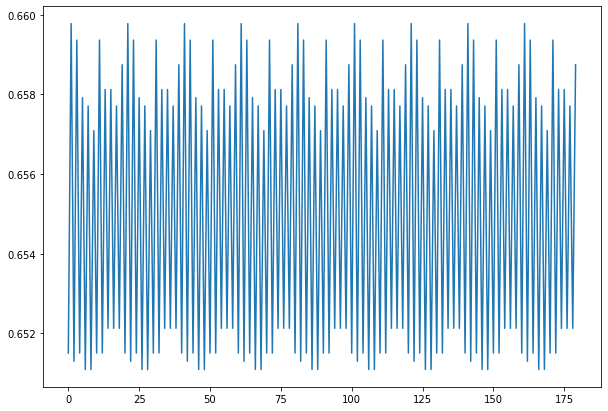

0.659776767259198
1


In [43]:
# LBMClassifier callibrator
history = []
for nl in range(10, 100, 10):
    for ne in range(200, 300, 10):
        for md in range(1,3):
            LGBMmodel = LGBMClassifier(num_leaves=100, n_estimators=200, max_depth=100)
            LGBMmodel.fit(X_train, y_train)
            ans = LGBMmodel.predict(X_test)
            acc = accuracy_score(y_test, ans)
            history.append(acc)
            
fig = plt.figure(figsize=(15,5))
plt.plot(history)
plt.show()
hst = np.array(history)
print(hst.max())
print(list(hst).index(hst.max()))
# So LGBMClassifier(num_leaves=10, n_estimators=200, max_depth=10)

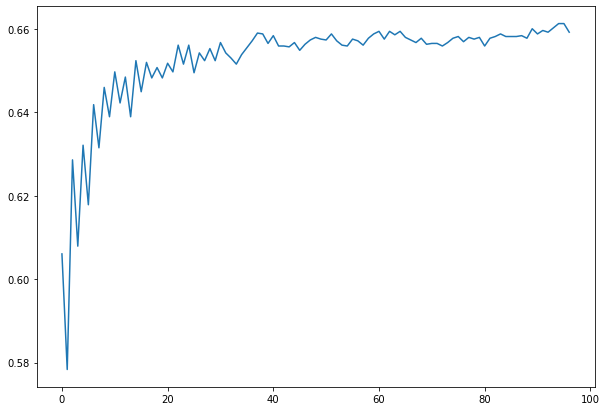

0.6612236461347665
94


In [51]:
# KNN Callibrator
history = []
for knn in range (3, 100):
    KNN_model = KNeighborsClassifier(n_neighbors=knn)
    KNN_model.fit(X_train, y_train)
    ans = KNN_model.predict(X_test)
    acc = accuracy_score(ans, y_test)
    history.append(acc)

fig = plt.figure(figsize=(15,5))
plt.plot(history)
plt.show()
hst = np.array(history)
print(hst.max())
print(list(hst).index(hst.max()))
# So the best K neighbors is 95

In [58]:
LGBM_model = LGBMClassifier(num_leaves=10, n_estimators=200, max_depth=10)
LGBM_model.fit(X_train, y_train)

DT_model = DecisionTreeClassifier(max_depth=19, min_samples_leaf=32)
DT_model.fit(X_train, y_train)

LGBMClassifier(max_depth=10, n_estimators=200, num_leaves=10)

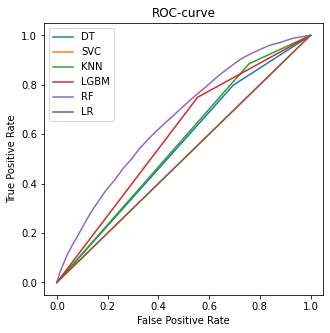

In [100]:
# Let us make some ROC-curves

fpr, tpr, thresholds = roc_curve(y_test, DT_model.predict(X_test))
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)

fpr1, tpr1, thresholds = roc_curve(y_test, SVC_model.predict(X_test))
plt.plot(fpr1, tpr1)

fpr2, tpr2, thresholds = roc_curve(y_test, KNN_model.predict(X_test))
plt.plot(fpr2, tpr2)

fpr3, tpr3, thresholds = roc_curve(y_test, LGBM_model.predict(X_test))
plt.plot(fpr3, tpr3)

fpr4, tpr4, thresholds = roc_curve(y_test, RF_model.predict(X_test))
plt.plot(fpr4, tpr4)

fpr5, tpr5, thresholds = roc_curve(y_test, LR_model.predict(X_test))
plt.plot(fpr5, tpr5)

plt.legend(['DT', 'SVC', 'KNN', 'LGBM', 'RF', 'LR'])

plt.title('ROC-curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

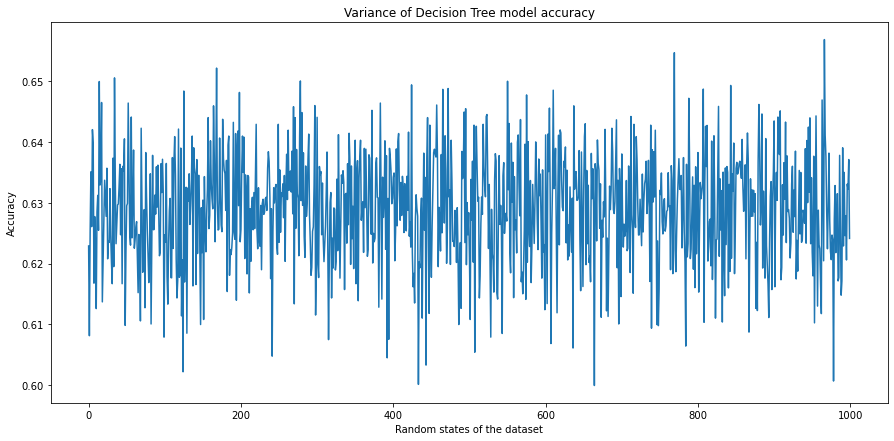

In [94]:
# Presto! We can train models with random data states to get mean and variance
#We start with Decision Tree Model

DT_rhistory = []

for r in range (1000):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=20+r) 
    DT_model = DecisionTreeClassifier(max_depth=19, min_samples_leaf=32, random_state=r)
    DT_model.fit(X_train, y_train)
    DT_prediction = DT_model.predict(X_test)
    DT_rhistory.append(accuracy_score(DT_prediction, y_test))
plt.figure(figsize=(15, 5))
#plt.ylim((0.6, 0.65))
plt.plot(DT_rhistory)
plt.title('Variance of Decision Tree model accuracy')
plt.xlabel('Random states of the dataset')
plt.ylabel('Accuracy')
plt.show()   

In [74]:
#Random Forest Model

RF_rhistory = []

for r in range (1000):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=20+r) 
    RF_model = RandomForestRegressor(n_estimators=46, max_features=0.2, random_state=r)
    RF_model.fit(X_train, y_train)
    RF_prediction = RF_model.predict(X_test)
    RF_prediction = np.where((RF_prediction < 0), -1, RF_prediction)
    RF_prediction = np.where((RF_prediction >= 0), 1, RF_prediction)
    RF_rhistory.append(accuracy_score(RF_prediction, y_test))
plt.figure(figsize=(15, 5))
#plt.ylim((0.6, 0.65))
plt.plot(RF_rhistory)
plt.title('Variance of Random Forest model accuracy')
plt.xlabel('Random states of the dataset')
plt.ylabel('Accuracy')
plt.show()

KeyboardInterrupt: 

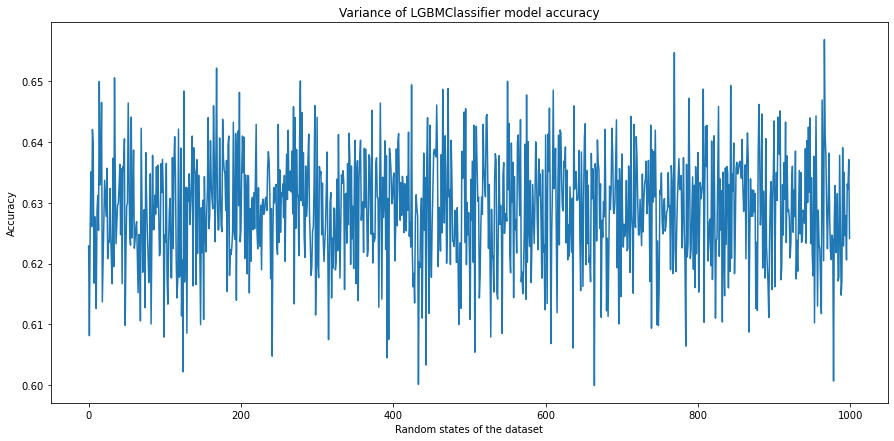

In [93]:
#LGBMClassifier Model

LGBM_rhistory = []

for r in range (50):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=20+r) 
    LGBM_model = LGBMClassifier(num_leaves=100, n_estimators=200, max_depth=100)
    LGBM_model.fit(X_train, y_train)
    LGBM_prediction = LGBM_model.predict(X_test)
    LGBM_rhistory.append(accuracy_score(LGBM_prediction, y_test))
plt.figure(figsize=(15, 5))
#plt.ylim((0.6, 0.65))
plt.plot(LGBM_rhistory)
plt.title('Variance of LGBMClassifier model accuracy')
plt.xlabel('Random states of the dataset')
plt.ylabel('Accuracy')
plt.show()

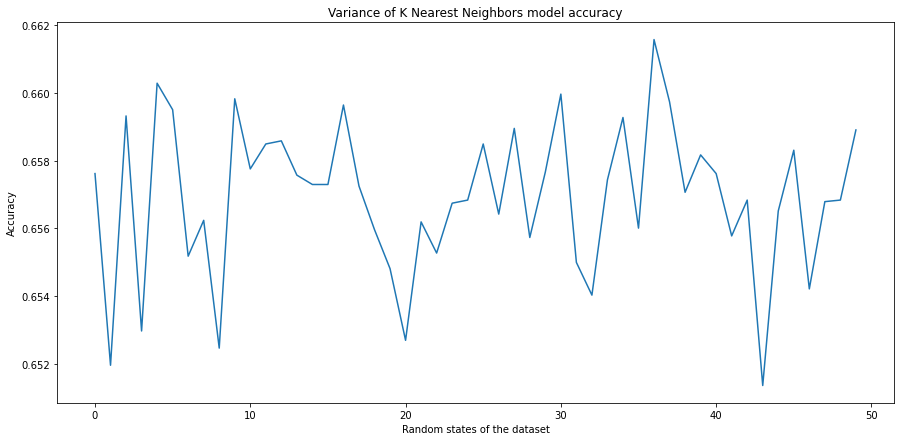

In [96]:
#KNN Model

KNN_rhistory = []

for r in range (50):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=20+r) 
    KNN_model = KNeighborsClassifier(n_neighbors=95)
    KNN_model.fit(X_train, y_train)
    KNN_prediction = KNN_model.predict(X_test)
    KNN_rhistory.append(accuracy_score(KNN_prediction, y_test))
plt.figure(figsize=(15, 5))
#plt.ylim((0.6, 0.65))
plt.plot(KNN_rhistory)
plt.title('Variance of K Nearest Neighbors model accuracy')
plt.xlabel('Random states of the dataset')
plt.ylabel('Accuracy')
plt.show()

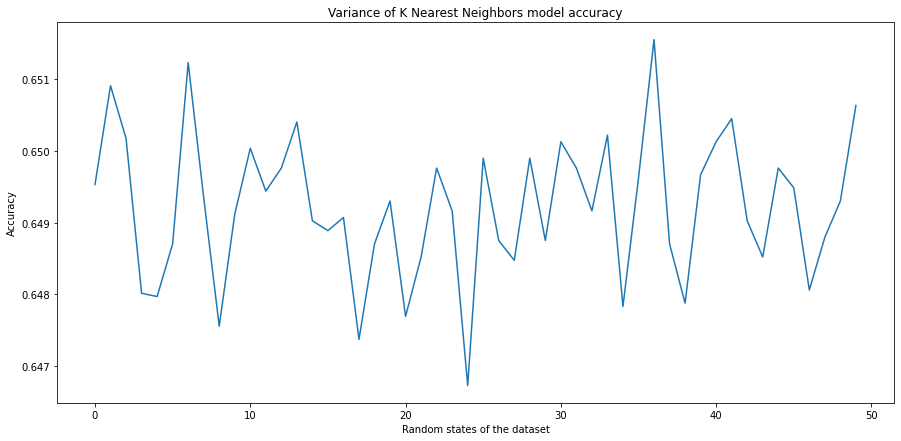

In [97]:
#SVC Model

SVC_rhistory = []

for r in range (50):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=20+r) 
    SVC_model = SVC_model = svm.SVC(kernel='linear')
    SVC_model.fit(X_train, y_train)
    SVC_prediction = SVC_model.predict(X_test)
    SVC_rhistory.append(accuracy_score(SVC_prediction, y_test))
plt.figure(figsize=(15, 5))
#plt.ylim((0.6, 0.65))
plt.plot(SVC_rhistory)
plt.title('Variance of Support Vector Machine model accuracy')
plt.xlabel('Random states of the dataset')
plt.ylabel('Accuracy')
plt.show()

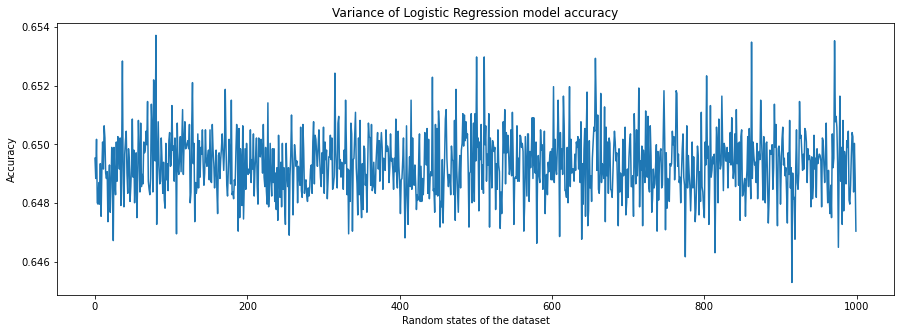

In [105]:
#LR Model

LR_rhistory = []

for r in range (1000):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=20+r) 
    LR_model = LogisticRegression(random_state=220-i)
    LR_model.fit(X_train, y_train)
    LR_prediction = LR_model.predict(X_test)
    LR_rhistory.append(accuracy_score(LR_prediction, y_test))
plt.figure(figsize=(15, 5))
#plt.ylim((0.6, 0.65))
plt.plot(LR_rhistory)
plt.title('Variance of Logistic Regression model accuracy')
plt.xlabel('Random states of the dataset')
plt.ylabel('Accuracy')
plt.show()

In [101]:
pd.DataFrame([RF_rhistory, DT_rhistory[:798], LR_rhistory[:798]]).transpose().describe()

,0,1,2
count,0.0,798.000000,798.000000
mean,NaN,0.628891,0.649317
std,NaN,0.009100,0.001081
min,NaN,0.599963,0.646178
25%,NaN,0.622979,0.648567
50%,NaN,0.629341,0.649256
75%,NaN,0.635233,0.650037
max,NaN,0.654631,0.653712


In [46]:
print("Mean = ", mean, "Si =", s_index, "Median = ", median, "Mi = ", m_index)
data1['Res'].median()

Mean =  0.4654507160223691 Si = 32 Median =  -0.255388159 Mi =  32


-0.2777487035

In [129]:
# Create datasets for ML || Need to rearrange for each data: base, ln, std, cleaned...
# Base as a baseline
X = ln_data.iloc[:,:-2]
Y = ln_data['Option'] 
X.head(1)

,Trend,LN_Vol
0,-0.547334,-0.932019


In [130]:
SVC_model = svm.SVC(kernel='linear')  
KNN_model = KNeighborsClassifier(n_neighbors=50)
DT_model = DecisionTreeClassifier(max_depth=19, min_samples_leaf=32)
RF_model = RandomForestRegressor(n_estimators=50, max_features=0.2)
LGBM_model = LGBMClassifier(num_leaves=10, n_estimators=200, max_depth=10)
LR_model = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=20) 

SVC_model.fit(X_train, y_train) 
KNN_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)
LR_model.fit(X_train, y_train)

SVC_prediction = SVC_model.predict(X) 
KNN_prediction = KNN_model.predict(X)
DT_prediction = DT_model.predict(X)
RF_prediction = RF_model.predict(X)
RF_prediction = np.where((RF_prediction < 0), -1, RF_prediction)
RF_prediction = np.where((RF_prediction >= 0), 1, RF_prediction)
LGBM_prediction = LGBM_model.predict(X)
LR_prediction = LR_model.predict(X)

#print(accuracy_score(SVC_prediction, y_test))  

In [146]:
data1 = data.copy()
data1['Option'] = SVC_prediction # SVC  KNN  DT  RF  LGBM  LR
data1['Res'] = np.where((data1.Option > 0), data1.CallOnly, data1.Res)
data1['Res'] = np.where((data1.Option < -0), data1.PutOnly, data1.Res)
data1.head(1)
#s = randint(0,100)

,Trend,STD_Trend,Vol,LN_Vol,STD_Vol,Hurst,STD_Hurst,Option,Res,CallOnly,PutOnly,TrueRes
0,-0.547334,-1.017391,0.393758,-0.932019,0.54827,0.640542,1.111607,1,1.008462,1.008462,-1.0,-1.0


In [147]:
cortege = [0, 0]
s_history = []
    
for r in range(1000):
    dttr, dtt, ytr, ytt = train_test_split(data1, base_data, test_size=0.005, random_state=s+r)
    cldtt = dtt.drop(dtt.columns[:8],axis=1)
    cldtt = cldtt.drop(cldtt.columns[1:],axis=1)
    cortege[0] = cldtt.median()
    cortege[1] = cldtt.mean()
    crt = [cortege[0][0],cortege[1][0]]
    #print(cortege)
    s_history.append(crt)

s_hist_pd = pd.DataFrame(s_history)
stats = s_hist_pd.describe()

In [148]:
writer = pd.ExcelWriter('C:/Users/prof-/OneDrive/Рабочий стол/ПНИПУ/FinanceMath/datas/SVC_stats_stoch.xlsx', engine= 'xlsxwriter')
stats.to_excel(writer, 'Sheet1')
writer.save()

In [43]:
answ = RF_model.predict(X)
data1 = data.copy()
data1['Option'] = answ
data1['Res'] = np.where((data1.Option > 0), data1.CallOnly, data1.Res)
data1['Res'] = np.where((data1.Option < -0), data1.PutOnly, data1.Res)
#data1['Option'] = np.where((data1.Option < 0), "Put", data1.Option)
#data1['Option'] = np.where((data1.Option != "Put"), "Call", data1.Option)
#dt['Option'] = np.where((dt.CallOnly < -0.5), -1, dt.Option)
data1.drop(data1.columns[:8], axis=1).describe()

,Res,CallOnly,PutOnly,TrueRes
count,24186.000000,24186.000000,24186.000000,24186.000000
mean,1.007027,0.289242,0.723467,0.324151
std,3.469655,1.756821,4.166402,2.681330
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000
50%,-0.098785,-0.277749,-1.000000,-0.970215
75%,1.391669,0.983410,-0.128552,0.691841
max,56.049352,56.049352,47.491587,56.049352


In [109]:
data.drop(data.columns[:8],axis=1).describe()

,Res,CallOnly,PutOnly
count,24186.000000,24186.000000,24186.000000
mean,0.291428,0.289242,0.723467
std,2.544246,1.756821,4.166402
min,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000
50%,-0.932324,-0.277749,-1.000000
75%,0.699383,0.983410,-0.128552
max,56.049352,56.049352,47.491587
